## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This will be a simple example of an A/B test.

In this project, I will work to understand the results of an A/B test that was run by an e-commerce website. The goal is to understand whether the company should update to the new webpage or keep the old webpage.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

`1.` Let's look at the dataset and see what it looks like.

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

The proportion of users converted.

In [5]:
df["converted"].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [1]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

NameError: name 'df' is not defined

Any missing values?

In [7]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


(None,              user_id      converted
 count  294478.000000  294478.000000
 mean   787974.124733       0.119659
 std     91210.823776       0.324563
 min    630000.000000       0.000000
 25%    709032.250000       0.000000
 50%    787933.500000       0.000000
 75%    866911.750000       0.000000
 max    945999.000000       1.000000)

Nope, doesn't look like any null or 0 values where there shouldn't be

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. So let's create a new dataset that makes sure everything is lined up.

In [8]:
#remove all rows where we can't trust the data
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions

How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192].head()

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Now, lets remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop([1899])

What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

What is the probability that an individual received the new page?

In [17]:
df2['landing_page'].value_counts(normalize=True)

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

**There is not sufficient evidence to say that the new treatment page leads to more conversions. With the new page, they only converted 11.88% of the time, while with the old page people converted 12.03% of the time.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?

`1.` Now, I am going to make a decision based on the data provided. I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. My hypothesis will be in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$: $p_{new}$ = $p_{old}$**

**$H_{0}$: $p_{new}$ > $p_{old}$**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
df2.converted.mean()

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null?

In [19]:
#same as pnew because in the null they are equal
df2.converted.mean()

0.11959708724499628

In [20]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

In [21]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
prob = df2.converted.mean()

new_page_converted = np.random.choice(2, n_new, p=[1-prob, prob])
#print mean to check if its right
new_page_converted.mean()

0.11822999105360953

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
prob = df2.converted.mean()

old_page_converted = np.random.choice(2, n_new, p=[1-prob, prob])
#print mean to check if its right
old_page_converted.mean()

0.11920721216709104

Find $p_{new}$ - $p_{old}$ for simulated values.

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0009772211134815162

Simulating 10,000 $p_{new}$ - $p_{old}$ Storing all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(2, n_new, p=[1-prob, prob])
    old_page_converted = np.random.choice(2, n_new, p=[1-prob, prob])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plotting a histogram of the **p_diffs**.

Text(0.5, 1.0, 'P_new and P_old Differences')

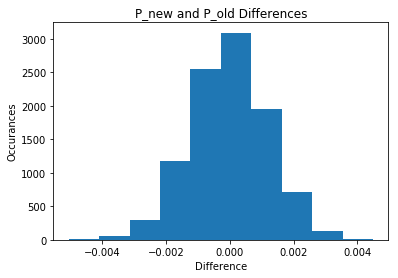

In [26]:
plt.hist(p_diffs)
plt.ylabel('Occurances')
plt.xlabel('Difference')
plt.title('P_new and P_old Differences')

This is what was expected because the data should be centered at 0 and have a normal distribution.

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
new_page_observed = df2[df2['group'] == 'treatment'].converted.mean() 
old_page_observed = df2[df2['group'] == 'control'].converted.mean()
observed_diff = new_page_observed - old_page_observed
p = []

for i in range(len(p_diffs)):
    p.append(p_diffs[i] > observed_diff)

sum(p) / len(p)

0.9019

**This is the p-value. This means that there is aronud a 90% chance that we will obtain a result that is the null hypothesis. This means that there is probably not a difference between the new and old pages.**

In [28]:
import statsmodels.api as sm

convert_old = df2[df2['group']=='control']['converted'].sum()
convert_new = df2[df2['group']=='treatment']['converted'].sum()
n_old = (df2['landing_page']=='old_page').sum()
n_new = (df2['landing_page']=='new_page').sum()

Using `stats.proportions_ztest` to compute your test statistic and p-value.

In [33]:
zstat, pval = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], alternative = 'smaller')
print(zstat)
print(pval)

1.3109241984234394
0.9050583127590245


In [34]:
from scipy.stats import norm

print(norm.cdf(zstat))

print(norm.ppf(1-(0.05)))

0.9050583127590245
1.6448536269514722


**Since the zstat is less than the critical value 1.64485, we fail to reject the null. This is similar to the conclusion we come to previously.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will come to the same conclusion using regression.<br><br>

**Logistic regression**

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  

Creating a column for the intercept, and creating a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
df2['intercept'] = 1
df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

Using **statsmodels** to import the regression model.  Instantiating the model, and fitting the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
logistic_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logistic_reg.fit()

In [ ]:
result.summary()

**P-value is 0.1899. For the first part, the null is there is no differnce between the old and new page, and the alternative is that there is a difference between the two groups. In the second part the null is the old page is better unless the new page can prove its better, this changes the p-value**

**We could use the timestamp to determine more info on when a user converts or not. Like which page was better at certain times of the day, like in the morning or at night. The disadvantage of adding more factors like this is it makes the model more complex and confusing**

Now, lets use the countries csv file to see if country had an impact on conversion.

In [ ]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df3 = df2.merge(countries_df, on='user_id', how='left')
df3.head()

In [ ]:
df3['country'].value_counts()

In [ ]:
### Creating the necessary dummy variables
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

# creating an intercept variable
df3['intercept'] = 1

In [2]:
### Fitting Linear Model And Obtaining the Results
log_reg = sm.Logit(df3['converted'], df3[['intercept', 'new_page', 'UK', 'US']])
log_reg.fit().summary()

NameError: name 'sm' is not defined

## Conclusions:

**Every time the new_page unit decreases, conversion rate is 1.5%  more likely**

**Every time the UK unit increases, conversion rate is 5.3% more likely**

**Every time the US unit increases, conversion rate is 4.3% more likely**